# Exercise 5: SVM

In this assignment you will use SKlearn’s implementation of an SVM classifier (called SVC).
First you will divide the data to training and test set.
Then, you will try different kernels using 5-fold cross validation.
You will select the best kernel according to the TPR and FPR (with α=1.5). In addition, you will plot the result of each kernel in a ROC graph. 

After selecting the best kernel, you will try different values for the parameter C (the slack regularization) in the same method as above.

Lastly, you will compute the performance of the chosen optimal kernel on the test set.



## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write vectorized code whenever possible.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in the provided `hw5.py` python module only. All the logic you write is imported and used in this jupyter notebook.
5. You are not allowed to add imports to `hw5.py`, even if you only used them for testing.
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install. Changes of the configuration we provided are at your own risk. Code that cannot run will also earn you the grade of 0.
7. Write your own code. Cheating will not be tolerated. 
8. Submission includes the `hw5.py` file and this notebook. Answers to qualitative questions should be written in markdown cells (with $\LaTeX$ support).
9. You are allowed to include additional functions.
10. Submission: zip containing only the completed jupyter notebook and the python file `hw5.py`. Do not include the data or any directories. Name the file `ID1_ID2.zip` and submit *only one copy* of the assignment.


## In this exercise you will perform the following:

1. Load the dataset and split it to train and test. Feature scaling and feature selection were done for you.
2. Train SVM classifiers with different kernels and kernel parameters using k-fold cross validation (using only the training dataset)
3. Plot results and choose the best configuration based on 2 different metrics - accuracy and score (as defined below)
4. Use the kernel with the best score, and do another round of hyper-parameter optimization, this time for different C values.
5. For the kernel with the best score, train on the entire train dataset, predict on the test dataset and present the results on the test dataset.

## important notes:
1. You will only be graded for the code in `hw5.py`
2. Each function you write will be tested automatically with python unit tests. you are not allowed to change the input or output formats of the functions.
3. In order to avoid variable type mistakes and make sure your format is correct, several tests were added for you within this notebook. In this exercise we use python's `assert` function.


In [119]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sklearn.datasets as datasets
from sklearn.svm import SVC
from numpy import count_nonzero, logical_and, logical_or, concatenate, mean, array_split, poly1d, polyfit
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [120]:
# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
from hw5.hw5 import *

# Part 1 - prepare data

We will work on a standard data set of breast cancer samples.


## TODO: implement function `prepare_data` (10 points)
Implement the function `prepare_data` that splits the data into train and test datasets.

Retrun values of `prepare_data` should be numpy arrays.

Notice that before splitting the data you are required to shuffle the dataset.

In [157]:
PRODUCTION_MODE = True 

if PRODUCTION_MODE:
    SAMPLES_COUNT = 350 
    FOLDS_COUNT = 5 
    TRAIN_RATIO = 0.7
else:
    SAMPLES_COUNT = 150 
    FOLDS_COUNT = 3 
    TRAIN_RATIO = 0.6

cancer = datasets.load_breast_cancer()

# data scaling and feature selection
selected_features = ['worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity']
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df[selected_features].head()
data = np.array(df[selected_features])


scaler = MinMaxScaler()
scaler.fit(data)
scaled_data = scaler.transform(data)
scaled_data[0]


,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity
0,184.60,2019.0,0.1622,0.6656,0.7119
1,158.80,1956.0,0.1238,0.1866,0.2416
2,152.50,1709.0,0.1444,0.4245,0.4504
3,98.87,567.7,0.2098,0.8663,0.6869
4,152.20,1575.0,0.1374,0.2050,0.4000


MinMaxScaler(copy=True, feature_range=(0, 1))

array([0.66831017, 0.45069799, 0.60113584, 0.61929156, 0.56861022])

In [166]:
train_data, train_labels, test_data, test_labels = prepare_data(scaled_data, cancer.target, train_ratio=TRAIN_RATIO, max_count=SAMPLES_COUNT)
print('original shape: ', scaled_data.shape)
print('train_ratio: ', TRAIN_RATIO)
print('max count: ', SAMPLES_COUNT)
print('\ntrain data shape: ',train_data.shape)
print('train labels shape: ', train_labels.shape)
print('test data shape: ', test_data.shape)
print('test labels shape: ', test_labels.shape)

assert round(SAMPLES_COUNT * TRAIN_RATIO) == train_data.shape[0] ,('data train shape isn\'t valid')
assert round(SAMPLES_COUNT * TRAIN_RATIO) == train_labels.shape[0], ('label train shape isn\'t valid')
assert SAMPLES_COUNT - round(SAMPLES_COUNT * TRAIN_RATIO) == test_data.shape[0], ('data test shape isn\'t valid')
assert SAMPLES_COUNT - round(SAMPLES_COUNT * TRAIN_RATIO) == test_labels.shape[0], ('label test shape isn\'t valid')


original shape:  (569, 5)
train_ratio:  0.7
max count:  350

train data shape:  (245, 4)
train labels shape:  (245,)
test data shape:  (105, 4)
test labels shape:  (105,)


# Part 2 - choose best kernel

For each kernel, build the SVM classifier on the training using 5-fold cross validation.
Calculate & print to the console the TPR and FPR on the test set.
Select the best kernel according to the best αTPR-FPR (with α=1.5).
The possible types for the kernel are:
Polynomial Kernel – with the following degrees {2,3,4}
RBF Kernel – with the following gamma values {1/200,1/20  ,1/2}


## TODO: implement function `get_stats`  (10 points)

The function recieves 2 arrays: `prediction` and `expected` and computes:
- true positive rate (tpr)
- false positive rate (fpr)
- accuracy

Notice - you are requested to compute these values on your own, without using pre-built functions.

In [167]:
# a simple test for validation.
# it is recommended to add more tests.
prediction = np.array([1,1,1,0,0])
labels = np.array([1,1,1,0,0])
tpr, fpr, accuracy = get_stats(prediction, labels)

assert tpr==1.0
assert fpr==0.0
assert accuracy==1.0

## TODO: implement function `get_k_fold_stats` (20 points)

This function recieves the following:

`clf` - a pre-configured sklearn learner

`folds_array` - a numpy array that contains K sub arrays of data

`labels_array`- a numpy array that contains K sub arrays of labels

The function computes K fold cross validation averages of `tpr`, `fpr` and `accuracy`


In [168]:
# a simple test for validation.
# it is recommended to add more tests.
clf=SVC(gamma='auto')

# a 3-folds arrays based on a dataset with 3 features and 12 samples
folds_array=[np.array([[1.846e+02, 2.019e+03, 1.622e-01],
        [1.588e+02, 1.956e+03, 1.238e-01],
        [1.525e+02, 1.709e+03, 1.444e-01],
        [9.887e+01, 5.677e+02, 2.098e-01]]),
 np.array([[1.522e+02, 1.575e+03, 1.374e-01],
        [1.034e+02, 7.416e+02, 1.791e-01],
        [1.532e+02, 1.606e+03, 1.442e-01],
        [1.106e+02, 8.970e+02, 1.654e-01]]),
 np.array([[1.062e+02, 7.393e+02, 1.703e-01],
        [9.765e+01, 7.114e+02, 1.853e-01],
        [1.238e+02, 1.150e+03, 1.181e-01],
        [1.365e+02, 1.299e+03, 1.396e-01]])]

# a 3-folds labels array based on the same dataset
labels_array = [np.array([1,1,0,0]),
                np.array([1,0,1,1]),
                np.array([0,1,0,0])]




mean_tpr, mean_fpr, mean_accuracy = get_k_fold_stats(folds_array, labels_array, clf)

assert 0.0<=mean_tpr<=1.0 
assert 0.0<=mean_fpr<=1.0 
assert 0.0<=mean_accuracy<=1.0 

## TODO: implement function `compare_svms` (25 points)

This function generates a dataframe  that compares the performance of classifiers with different hyper-parameters on a given (shuffeled) dataset with k-fold cross validation.
Each row in the resulting dataframe contains the given classifier and and its average `tpr`, `fpr` and `accuracy` using k-fold cross validation.

you are allowed to assume that this function only handles sklearn `SVC` classifiers.

In [169]:
# a simple test for validation.
# it is recommended to add more tests.
# a dataset with 3 features and 12 samples
data_array=np.array([[1.846e+02, 2.019e+03, 1.622e-01],
                    [1.588e+02, 1.956e+03, 1.238e-01],
                    [1.525e+02, 1.709e+03, 1.444e-01],
                    [9.887e+01, 5.677e+02, 2.098e-01],
                    [1.522e+02, 1.575e+03, 1.374e-01],
                    [1.034e+02, 7.416e+02, 1.791e-01],
                    [1.532e+02, 1.606e+03, 1.442e-01],
                    [1.106e+02, 8.970e+02, 1.654e-01],
                    [1.062e+02, 7.393e+02, 1.703e-01],
                    [9.765e+01, 7.114e+02, 1.853e-01],
                    [1.238e+02, 1.150e+03, 1.181e-01],
                    [1.365e+02, 1.299e+03, 1.396e-01]])

# a 3-folds labels array based on the same dataset
labels_array = np.array([1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0])


res = compare_svms(data_array,
                 labels_array,
                 folds_count=2,
                 kernels_list=('poly', 'poly'),
                 kernel_params=({'degree': 1}, {'degree': 2}))

res

assert np.allclose([0.5, 0.333], res.tpr.tolist(), atol=0.1)
assert np.allclose([0.166667, 0.5], res.fpr.tolist(), atol=0.1)
assert np.allclose([0.666667, 0.416667], res.accuracy.tolist(), atol=0.1)

,kernel,kernel_params,tpr,fpr,accuracy
0,poly,{'degree': 1},0.500000,0.166667,0.666667
1,poly,{'degree': 2},0.333333,0.500000,0.416667


# Part 3 - compute the different SVMs and choose the best kernel and plot results

In [170]:
res = compare_svms(train_data,
                   train_labels,
                   folds_count=FOLDS_COUNT) # run the compare svms function on the train dataset


#adding the score column
res['score'] = res.apply(lambda x: ALPHA*x.tpr-x.fpr, axis=1)
res


,kernel,kernel_params,tpr,fpr,accuracy,score
0,poly,{'degree': 2},1.000000,0.515128,0.779592,0.984872
1,poly,{'degree': 3},1.000000,0.976282,0.587755,0.523718
2,poly,{'degree': 4},1.000000,1.000000,0.575510,0.500000
3,rbf,{'gamma': 0.005},1.000000,1.000000,0.575510,0.500000
4,rbf,{'gamma': 0.05},1.000000,0.304145,0.869388,1.195855
5,rbf,{'gamma': 0.5},0.987488,0.082244,0.955102,1.398988


## TODO: implement `get_most_accurate_kernel` (5 points)

This function should return the row number in the `res` dataframe with the highest *accuracy*

In [171]:
accurate_kernel_idx = get_most_accurate_kernel(res['accuracy'])
print ("the chosen kernel is : %s.\n\nkernel details: \n%s" % (accurate_kernel_idx, res.iloc[accurate_kernel_idx]))

the chosen kernel is : 5.

kernel details: 
kernel                      rbf
kernel_params    {'gamma': 0.5}
tpr                    0.987488
fpr                   0.0822436
accuracy               0.955102
score                   1.39899
Name: 5, dtype: object


## TODO: implement `get_kernel_with_highest_score` (5 points)

This function should return the row number in the `res` dataframe with the highest *score*

In [172]:
best_kernel_idx = get_kernel_with_highest_score(res['score'])
print ("the chosen kernel is : %s.\n\nkernel details: \n%s" % (best_kernel_idx, res.iloc[best_kernel_idx]))


the chosen kernel is : 5.

kernel details: 
kernel                      rbf
kernel_params    {'gamma': 0.5}
tpr                    0.987488
fpr                   0.0822436
accuracy               0.955102
score                   1.39899
Name: 5, dtype: object


## TODO: implement `plot_roc_curve_with_score` (10 points)

This function receives the result dataframe and the alpha used to calculate the score.
It should create a scatter plot of the ROC curve (TPR vs FPR) and add a straight line in the form :
                                        $$y=\alpha*x + b$$
that passes through the best kernel in the graph (i.e., with the highest *score*)
Note: this can be a different point than the point with highest accuracy.

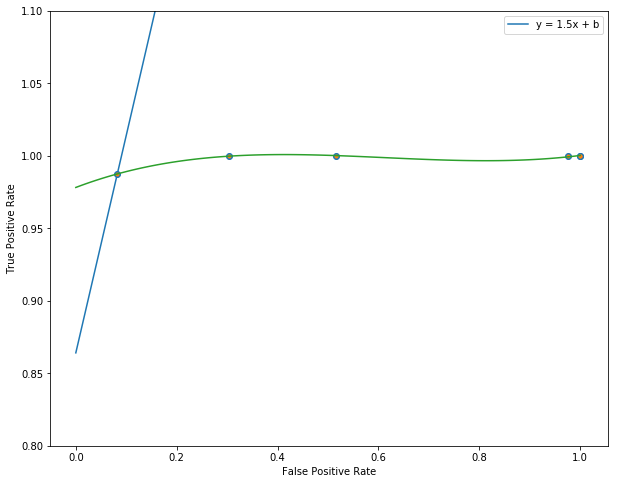

In [173]:
plot_roc_curve_with_score(res, alpha_slope=1.5)

# Part 4: choose the optimal C value for the chosen kernel 

For the kernel with the best *score*, examine C values that are all the combinations 
$$\{{10^i*\frac{j}{3}}\}, \quad \textrm{where} \quad i=\{1,0,-1,-2,-3,-4\} \quad \textrm{and} \quad  j={ 3,2,1}  $$




## TODO: implement function `evaluate_c_param` (5 points)

The function `evaluate_c_param` should use the function `compare_svms`, but this time evaluate the same kernel for different C values as described above.

The return value should be similar to `compare_svms`.


In [185]:
kernel = res.loc[best_kernel_idx,'kernel']
res_c_param = evaluate_c_param(train_data,train_labels, FOLDS_COUNT, kernel)

In [186]:
res_c_param['score'] = res_c_param.apply(lambda x: ALPHA*x.tpr-x.fpr, axis=1)

res_c_param

,kernel,kernel_params,tpr,fpr,accuracy,score
0,rbf,{'C': 3.333333333333333},0.993548,0.072244,0.963265,1.418079
1,rbf,{'C': 6.666666666666666},0.993548,0.064551,0.967347,1.425771
2,rbf,{'C': 10.0},0.993548,0.064551,0.967347,1.425771
3,rbf,{'C': 0.3333333333333333},1.000000,0.216731,0.902041,1.283269
4,rbf,{'C': 0.6666666666666666},0.987488,0.166517,0.918367,1.314715
5,rbf,{'C': 1.0},0.987488,0.137073,0.930612,1.344159
6,rbf,{'C': 0.03333333333333333},1.000000,1.000000,0.575510,0.500000
7,rbf,{'C': 0.06666666666666667},1.000000,1.000000,0.575510,0.500000
8,rbf,{'C': 0.1},1.000000,0.806838,0.653061,0.693162
9,rbf,{'C': 0.003333333333333333},1.000000,1.000000,0.575510,0.500000


poly1d([0.27519986, 0.80664185])

(0, 1.5)

Text(0, 0.5, 'True positive rate')

Text(0.5, 0, 'False positive rate')

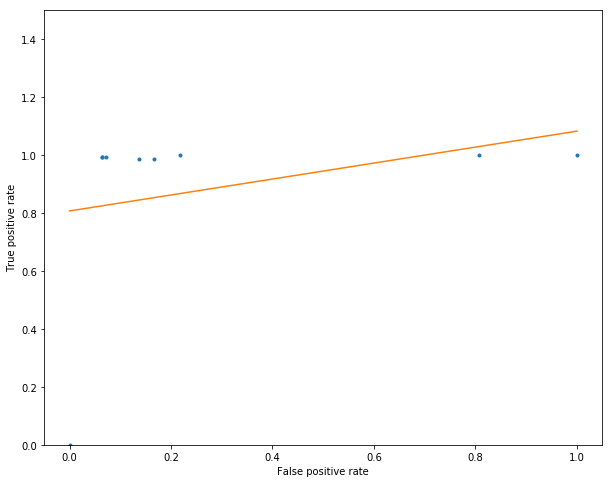

In [232]:
# plotting the ROC curve
res_c_bug_fix = res_c_param[res_c_param.loc[:,'score'] > 0.5].sort_values('fpr')

x=[0]+res_c_bug_fix.fpr.tolist()+[1]
y=[0]+res_c_bug_fix.tpr.tolist()+[1]

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
xp = np.linspace(0, 1, 100)
p
_ = plt.plot(x, y, '.', xp, p(xp), '-')
plt.ylim(0,1.5)
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

# Part 5: choose kernel and C value, and evaluate performance on the test dataset

## TODO: implement function `get_test_set_performance`  (10 points)

Train the chosen SVM on the entire train data. 
Then, predict on the test data and return the performance metrics of the train and test

In [183]:
kernel_chosen = res.loc[best_kernel_idx,'kernel']
kernel_params_chosen = res.loc[best_kernel_idx,'kernel_params']
kernel_params_chosen.update(res_c_param.loc[get_kernel_with_highest_score(res_c_param),'kernel_params'])

kernel_type, kernel_params, clf, tpr, fpr, accuracy = get_test_set_performance(train_data, train_labels, test_data, test_labels,kernel_chosen,kernel_params_chosen)

print("the chose kernel is: %s. \noptimal parameters: %s." % (kernel_type, kernel_params))
print("test dataset: %s samples, %s positives, %s negatives" % (len(test_labels),np.count_nonzero(test_labels==1), np.count_nonzero(test_labels==0)))
print("performance on test set: tpr: %s, fpr: %s, accuracy: %s" % (tpr, fpr, accuracy))

the chose kernel is: rbf. 
optimal parameters: {'gamma': 0.5, 'C': 3.333333333333333}.
test dataset: 105 samples, 51 positives, 54 negatives
performance on test set: tpr: 1.0, fpr: 0.07407407407407407, accuracy: 0.9619047619047619
